# Data analysis for Introduction and Chapter "Ensemble properties"

In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from ast import literal_eval

from data_analysis_helper_fun import *


In [2]:
# relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha_001-150'
data_file_name = f'{data_set_name}.csv.tar.gz'

data_set_name = 're_data_tau_alpha_01-100'
data_file_name = f'{data_set_name}.tar.gz'

data_set_name = 're_data_tau_alpha_mini'
data_file_name = f'{data_set_name}.tar.gz'


#data_dir = '/home/sebastian/tmp/can-be-deleted/re-technical-report/'
#data_file_name = 're_data_tau_alpha.csv'


tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")


In [3]:
usecols = ['model_name', 'ds', 'init_coms', 'n_sentence_pool', 'error_code' , 'process_length', 
           'coms_evolution', 'weight_account', 'weight_systematicity', 'weight_faithfulness',
           'ds_infer_dens', 'init_coms_size', 'init_coms_dia_consistent', 'n_global_optima',
           'init_final_coms_simple_hamming', 'n_fixed_points',
            #'coms_evolution','theory_evolution',
           'global_optima']
re_data= load_re_data(data_dir, data_file_name,
                 usecols=usecols,
                 filter_erroneous_runs=False)

In [4]:
print(f"The data set contains {sum(re_data['error_code'].isna()==False)}/{len(re_data)} rows of erroneous model runs.")
# filter
re_data = re_data.loc[re_data['error_code'].isna()]

The data set contains 87/349406 rows of erroneous model runs.


In [5]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())

General information: 
   Amount of rows: 349319
   Number of dialectical structures: 20
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']


In [6]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'ds_infer_dens',
       'weight_account', 'weight_systematicity', 'weight_faithfulness',
       'init_coms', 'init_coms_size', 'init_coms_dia_consistent',
       'init_final_coms_simple_hamming', 'coms_evolution', 'process_length',
       'error_code', 'n_fixed_points', 'global_optima', 'n_global_optima',
       'model_short_name'],
      dtype='object')

In [7]:
# counting simulation setups
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         'weight_faithfulness', 
                         'init_coms'
                        ])
re_data_unique_setups.groupby(['model_name']).size()

model_name
LinearGlobalRE       14400
LinearLocalRE        14330
QuadraticGlobalRE    14399
QuadraticLocalRE     14384
dtype: int64

In [8]:
# For the global optima we want to compare linear and quadratic variants. For a proper labeling we include another columns.
# df["group"] = df["group"].map({0: "zero", 1; "one"})
re_data['q_or_l_model'] = re_data['model_name'].map({'QuadraticGlobalRE':'QuadraticRE', 
                                                     'LinearGlobalRE':'LinearRE', 
                                                     'QuadraticLocalRE':'QuadraticRE', 
                                                     'LinearLocalRE':'LinearRE'})

## Dialectical structures

### Distribution: inferential density

In [9]:
re_data.drop_duplicates(["ds"])["ds_infer_dens"].describe()

count    20.000000
mean      0.308640
std       0.088621
min       0.176880
25%       0.235340
50%       0.306986
75%       0.373151
max       0.456092
Name: ds_infer_dens, dtype: float64

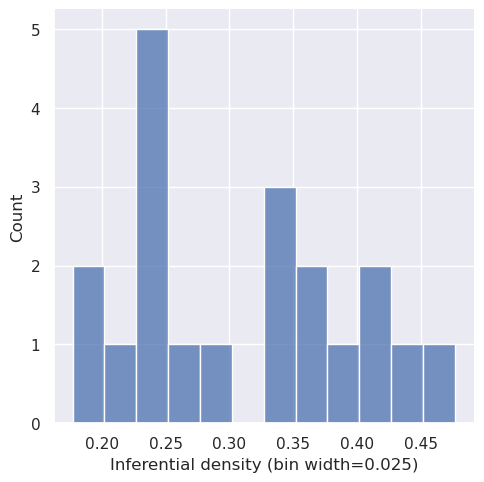

In [10]:
#re_data.drop_duplicates(["ds", "ds_infer_dens"])
g = sns.displot(re_data.drop_duplicates(["ds"]), x="ds_infer_dens", binwidth=0.025)#, discrete=True) 
g.set_axis_labels(x_var='Inferential density (bin width=0.025)')
g.savefig(path.join(figures_output_dir, 'distr-inf-dens.pdf'), bbox_inches='tight')
g.savefig(path.join(figures_output_dir, 'distr-inf-dens.png'), bbox_inches='tight')

### Distribution: mean number of premises

count    20.000000
mean      1.449901
std       0.361058
min       1.000000
25%       1.156250
50%       1.428571
75%       1.723214
max       2.000000
Name: ds, dtype: float64

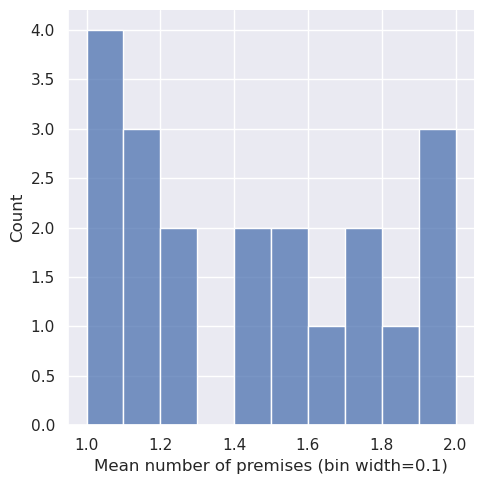

In [11]:
from statistics import mean
# WARNING: do not use `literal_eval` on unsave/unknow data
ser_ds = re_data.drop_duplicates(["ds"])["ds"]
ser_ds = ser_ds.apply(lambda x: literal_eval(x))
ser_ds = ser_ds.apply(lambda tau: mean([len(arg)-1 for arg in tau]))
display(ser_ds.describe())
#display(ser_ds)
g = sns.displot(ser_ds, binwidth=0.1)

g.set_axis_labels(x_var='Mean number of premises (bin width=0.1)')
g.savefig(path.join(figures_output_dir, 'mean-number-premises.pdf'), bbox_inches='tight')
g.savefig(path.join(figures_output_dir, 'mean-number-premises.png'), bbox_inches='tight')

## Initial commitments

### Consistency

In [12]:
# mean number of dialectically consistent positions
print(sum(re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"])/len(re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"]))
#re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"].describe()

0.5625


/tmp/ipykernel_2970129/3798926768.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rel_consistent_coms = re_data.drop_duplicates(["init_coms","ds","n_sentence_pool"])[["init_coms","ds","n_sentence_pool","init_coms_dia_consistent"]].groupby("n_sentence_pool").mean()


,init_coms_dia_consistent
n_sentence_pool,
6,0.58
7,0.67
8,0.56
9,0.44


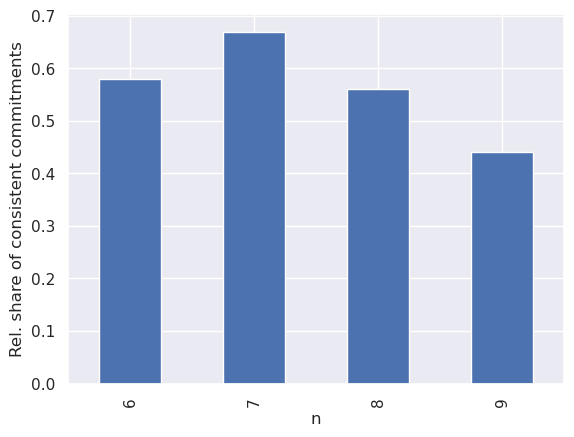

In [13]:
# mean number for different sentence pools
rel_consistent_coms = re_data.drop_duplicates(["init_coms","ds","n_sentence_pool"])[["init_coms","ds","n_sentence_pool","init_coms_dia_consistent"]].groupby("n_sentence_pool").mean()
display(rel_consistent_coms)
ax = rel_consistent_coms.plot(kind="bar")
plt.xlabel ('n')
plt.ylabel ('Rel. share of consistent commitments')
ax.get_legend().remove()

plt.savefig(path.join(figures_output_dir, 'consistency-init-coms.pdf'), bbox_inches='tight')
plt.savefig(path.join(figures_output_dir, 'consistency-init-coms.png'), bbox_inches='tight')

### Size of initial commitments

In [16]:
re_data.drop_duplicates(["init_coms"])['init_coms_size'].describe()

count    80.00000
mean      4.91250
std       1.49424
min       2.00000
25%       4.00000
50%       5.00000
75%       6.00000
max       9.00000
Name: init_coms_size, dtype: float64

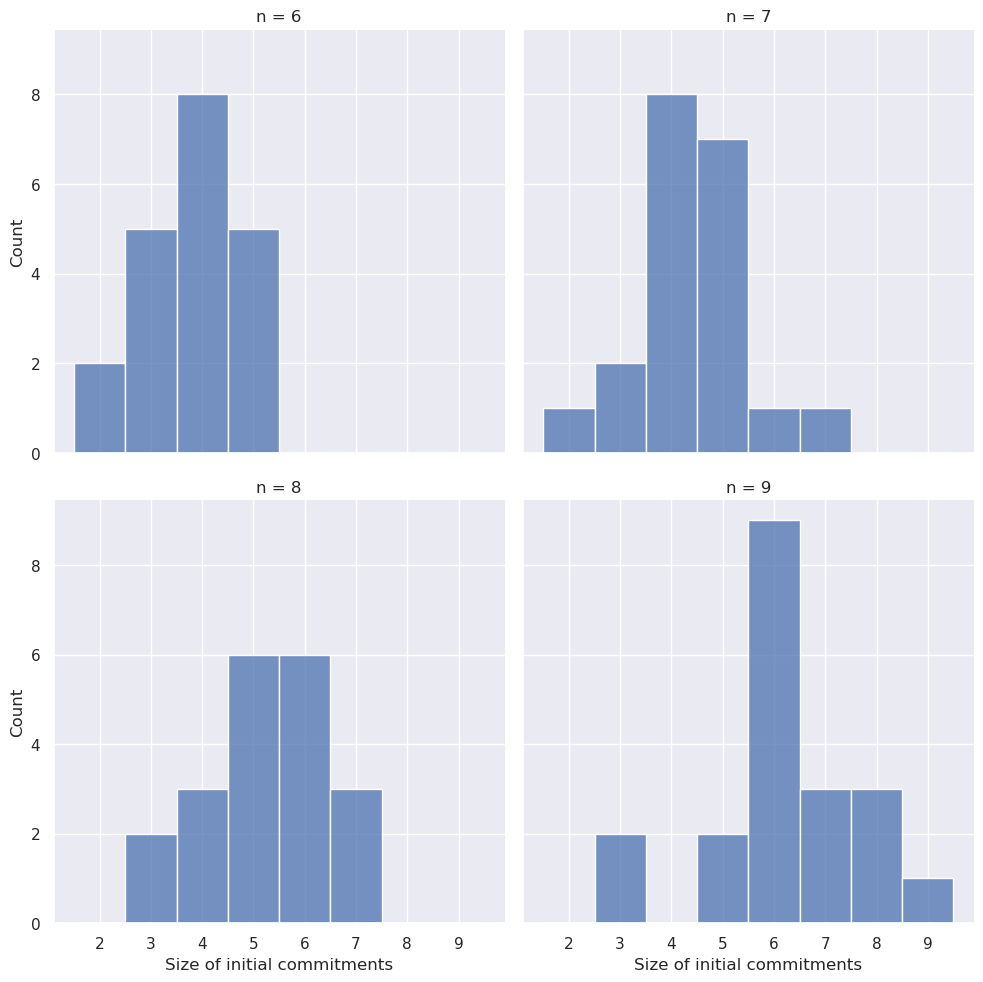

In [17]:
g = sns.displot(re_data.drop_duplicates(['init_coms', 'n_sentence_pool']), x='init_coms_size', 
            col='n_sentence_pool', col_wrap=2, discrete=True) 
g.set_axis_labels(x_var='Size of initial commitments')
#g.set_titles(row_template=f'{col_var}')
g.set_titles("n = {col_name}")
g.savefig(path.join(figures_output_dir, 'size-init-coms.pdf'), bbox_inches='tight')
g.savefig(path.join(figures_output_dir, 'size-init-coms.png'), bbox_inches='tight')

## Process length

In [18]:
re_data.head()[['coms_evolution', 'process_length']]

,coms_evolution,process_length
0,"[{1, 3, -2, -5}, {1, 3, -6, -5, -4, -2}, {1, 3...",6
1,"[{2, -5, 6}, {2, -5, 6}]",4
2,"[{2, -5, -4, -3}, {2, 6, -5, -4, -3, -1}, {2, ...",6
3,"[{2, -5, -4, -3}, {2, 6, -5, -4, -3, -1}, {2, ...",6
4,"[{5, -4, -3, -1}, {5, 6, -4, -3, -1}, {5, 6, -...",8


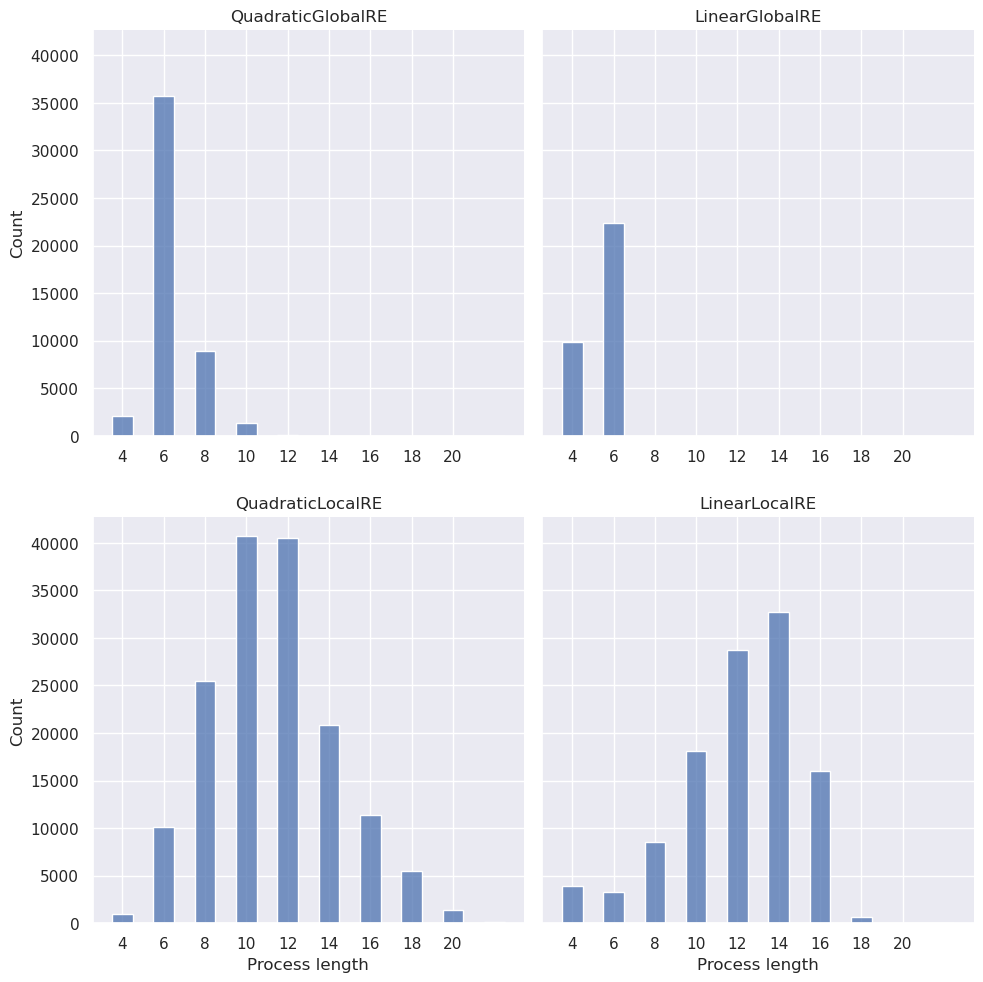

In [19]:
g = sns.displot(re_data, x='process_length', col='model_name', 
                col_wrap=2, discrete=True) 
g.set_axis_labels(x_var='Process length')
g.set_titles("{col_name}")
plt.xticks([i*2 for i in range(2,11)])
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace=0.2)

g.savefig(path.join(figures_output_dir, 'dist-process-length.pdf'), bbox_inches='tight')
g.savefig(path.join(figures_output_dir, 'dist-process-length.png'), bbox_inches='tight')

Here, we consider all branches.

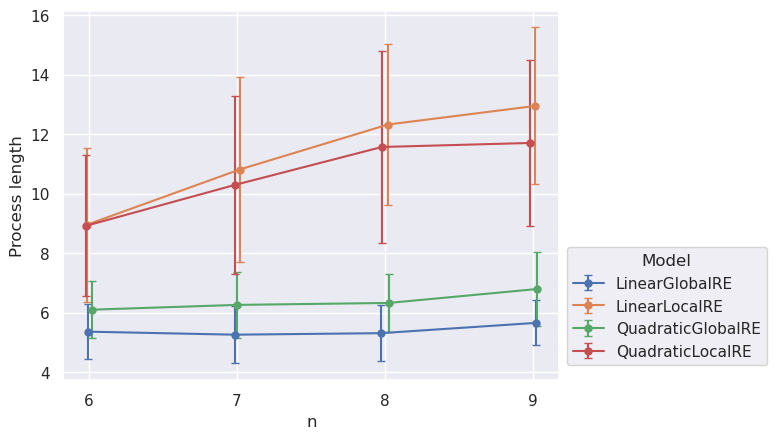

In [20]:
plot_multiple_error_bars(data=re_data, 
                         var_y='process_length', 
                         ylabel='Process length',
                         file_name='process-length', output_dir=figures_output_dir)

## Step length

In [21]:
# for each branch: the mean distance between adjacent commitments in the evolution of commitments
re_data['mean_step_size_coms'] = re_data.apply(lambda x: mean_simple_hamming_adjacents(list(x['coms_evolution'])[:-1]), axis = 1)

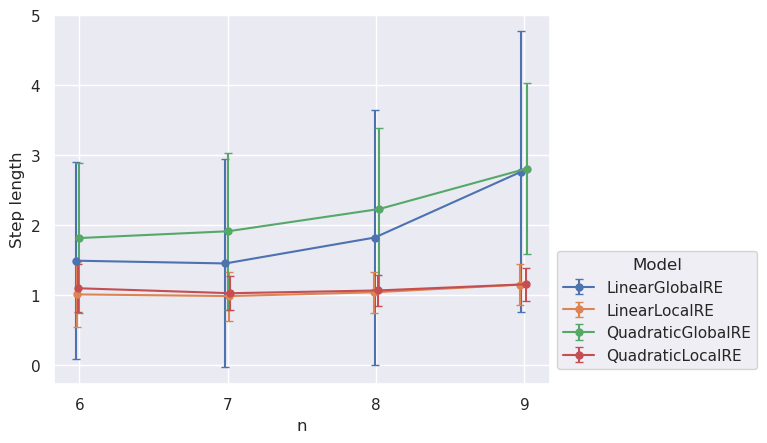

In [22]:
plot_multiple_error_bars(data=re_data, 
                         var_y='mean_step_size_coms', 
                         ylabel='Step length',
                         file_name='step-length', output_dir=figures_output_dir)

## Distance init coms to fixed points coms

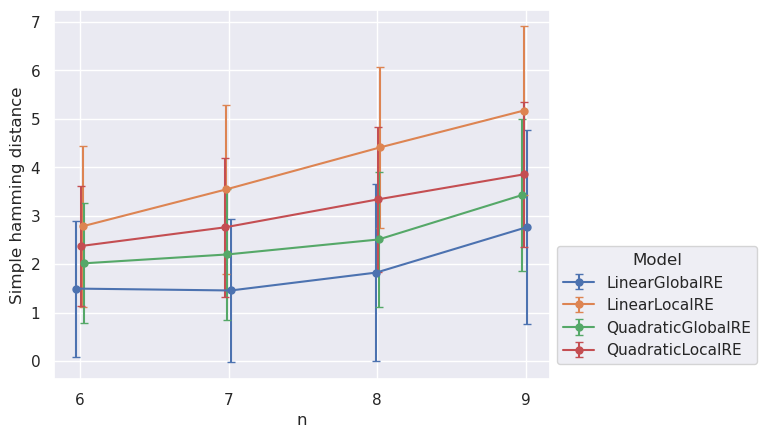

In [23]:
# init_final_coms_simple_hamming
plot_multiple_error_bars(data=re_data, 
                         var_y='init_final_coms_simple_hamming', 
                         ylabel='Simple hamming distance',
                         file_name='distance-init-final-coms', output_dir=figures_output_dir)

## Global optima

### Number of global optima

In [24]:
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)



In [25]:
data_collapsed.groupby('model_name')['n_global_optima'].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
LinearGlobalRE,14400.0,4.163125,13.735549,1.0,1.0,2.0,4.0,448.0
LinearLocalRE,14330.0,4.164829,13.767728,1.0,1.0,2.0,4.0,448.0
QuadraticGlobalRE,14399.0,4.454545,8.661818,1.0,1.0,2.0,4.0,220.0
QuadraticLocalRE,14384.0,4.454324,8.663445,1.0,1.0,2.0,4.0,220.0


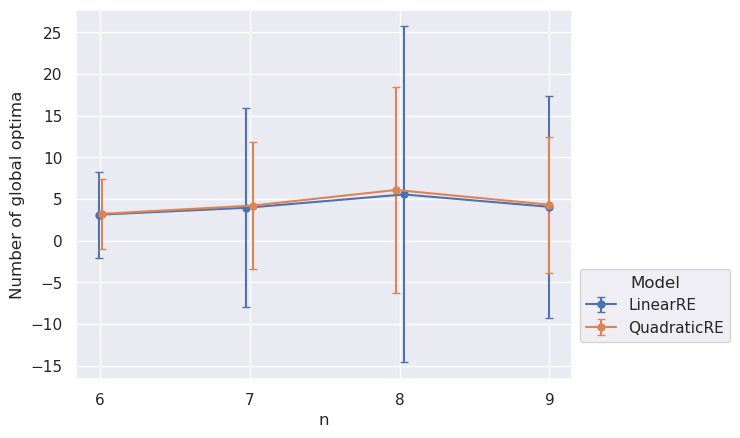

In [26]:
# n_global_optima (by model)
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='n_global_optima', 
                         ylabel='Number of global optima',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name='number-global-optima', output_dir=figures_output_dir)


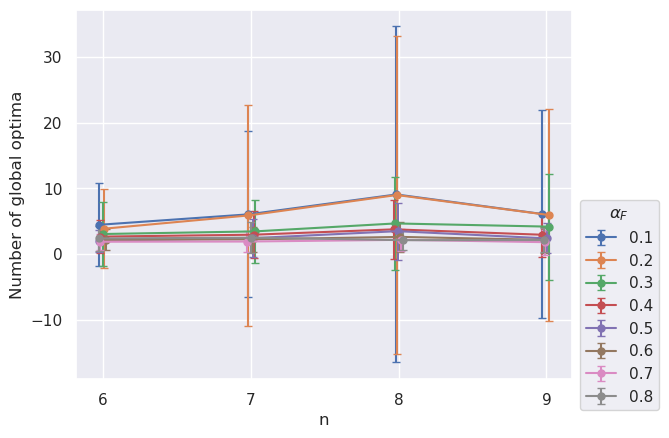

In [27]:
# n_global_optima (by alpha_f)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_global_optima', 
                         ylabel='Number of global optima',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name='number_global_optima', output_dir=figures_output_dir)


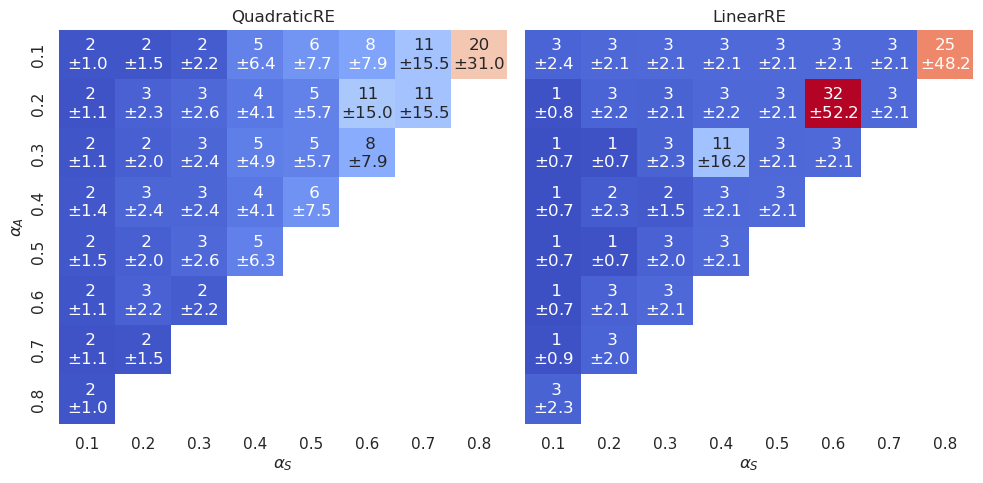

In [28]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                     values = 'n_global_optima', 
                     #title = 'Mean number of global optima', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=32,
                     col_model='q_or_l_model',
                     file_name='hm-mean-n-global-optima', output_dir=figures_output_dir)

### Mean distance of global optima

In [29]:
   
re_data['distance_go'] = re_data.apply(lambda x: mean_simple_hamming_distance([go_coms for go_theory, go_coms in x['global_optima']]), axis=1) 
# for some calcuations we need only one row per simulation set-up (and not all branches)
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

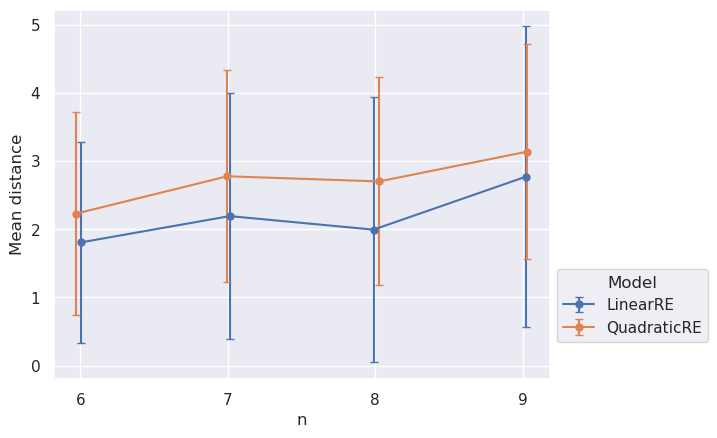

In [30]:
# by model
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='distance_go', 
                         ylabel='Mean distance',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name='mean-distance-global-optima-n', output_dir=figures_output_dir)


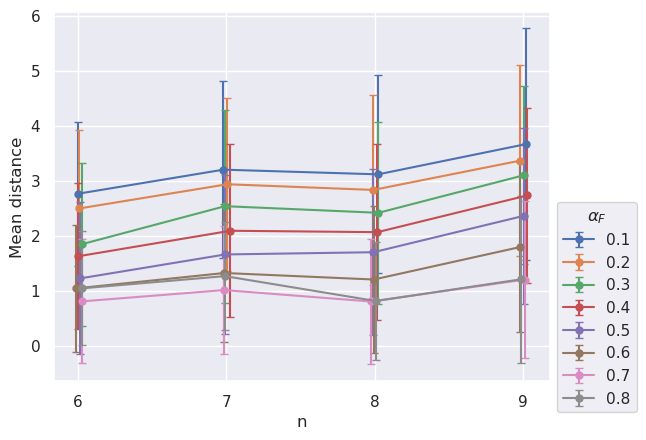

In [31]:
# by alpha_f
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='distance_go', 
                         ylabel='Mean distance',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name='mean-distance-global-optima-al', output_dir=figures_output_dir)


                         

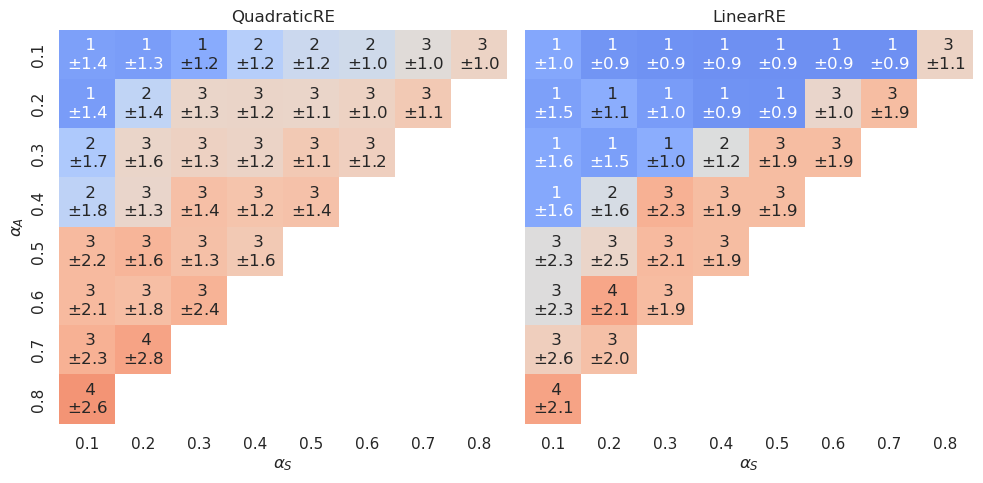

In [32]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                    values = 'distance_go', 
                    #title = 'Mean distance', 
                    col_model='q_or_l_model',
                    annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', 
                    vmin=0, vmax=5,
                    file_name='hm-mean-distance-global-optima', output_dir=figures_output_dir)

### Distance initital and global optima commitments

In [33]:
# mean distance of go commitments to initial commitments
re_data['mean_distance_init_coms_go'] = re_data.apply(mean_d_init_coms_go, axis=1)

In [34]:
# restrict data to unique simulation setups to prevent multiple counting of branches 
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

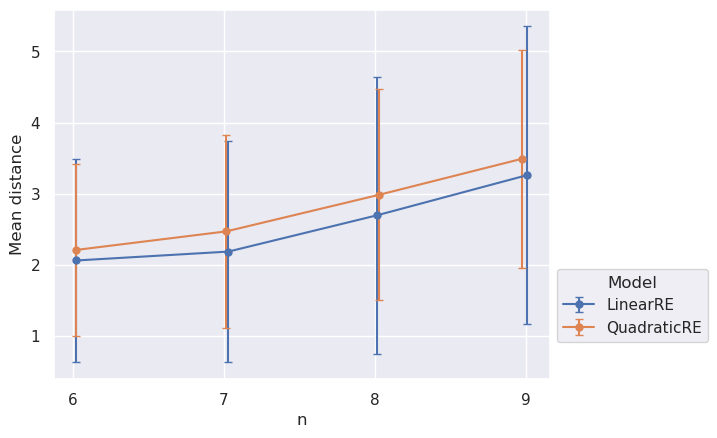

In [35]:
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='mean_distance_init_coms_go', 
                         ylabel='Mean distance',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name='distance-go-coms-n',
                         output_dir=figures_output_dir)

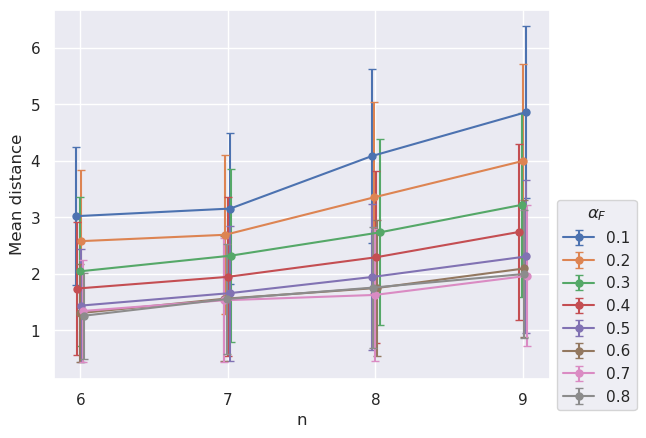

In [36]:
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='mean_distance_init_coms_go', 
                         ylabel='Mean distance',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name='distance-go-coms-al',
                         output_dir=figures_output_dir)

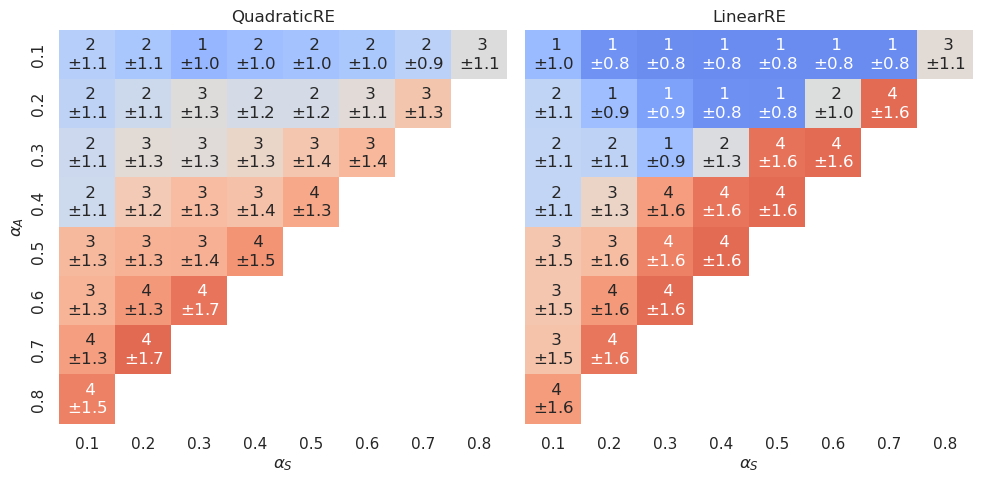

In [37]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                    values = 'mean_distance_init_coms_go', 
                    #title = 'Distance initial and go commitments', 
                    col_model='q_or_l_model',
                    annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', 
                    vmin=0, vmax=5,
                    file_name='hm-mean-distance-init-coms-go', output_dir=figures_output_dir)

## Branches

### Counting fixed points

In [38]:
# n_fixed_points

In [39]:
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

In [40]:
data_collapsed.groupby('model_name')['n_fixed_points'].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
LinearGlobalRE,14400.0,2.236806,4.495003,1.0,1.0,1.0,2.0,192.0
LinearLocalRE,14330.0,1.598535,1.690584,1.0,1.0,1.0,1.0,40.0
QuadraticGlobalRE,14399.0,2.897771,5.478072,1.0,1.0,2.0,3.0,160.0
QuadraticLocalRE,14384.0,3.868395,4.304930,1.0,1.0,3.0,4.0,57.0


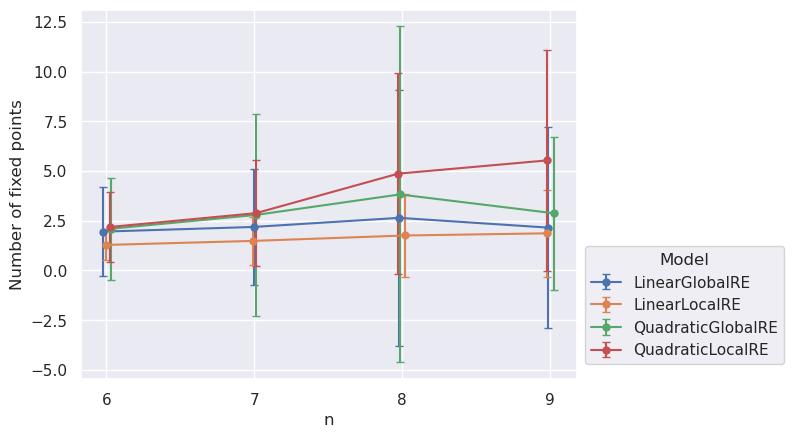

In [41]:
# n_fixed_points (by model)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_fixed_points', 
                         ylabel='Number of fixed points',
                         file_name='number_fixed_points', output_dir=figures_output_dir)


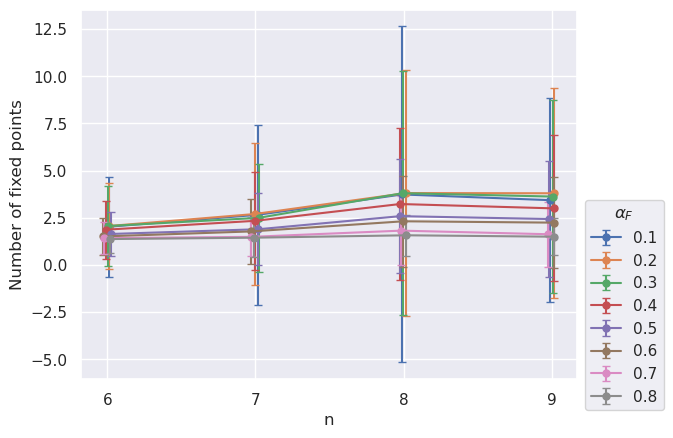

In [42]:
# n_fixed_points (by alpha_f)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_fixed_points', 
                         ylabel='Number of fixed points',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name='number_global_optima', output_dir=figures_output_dir)


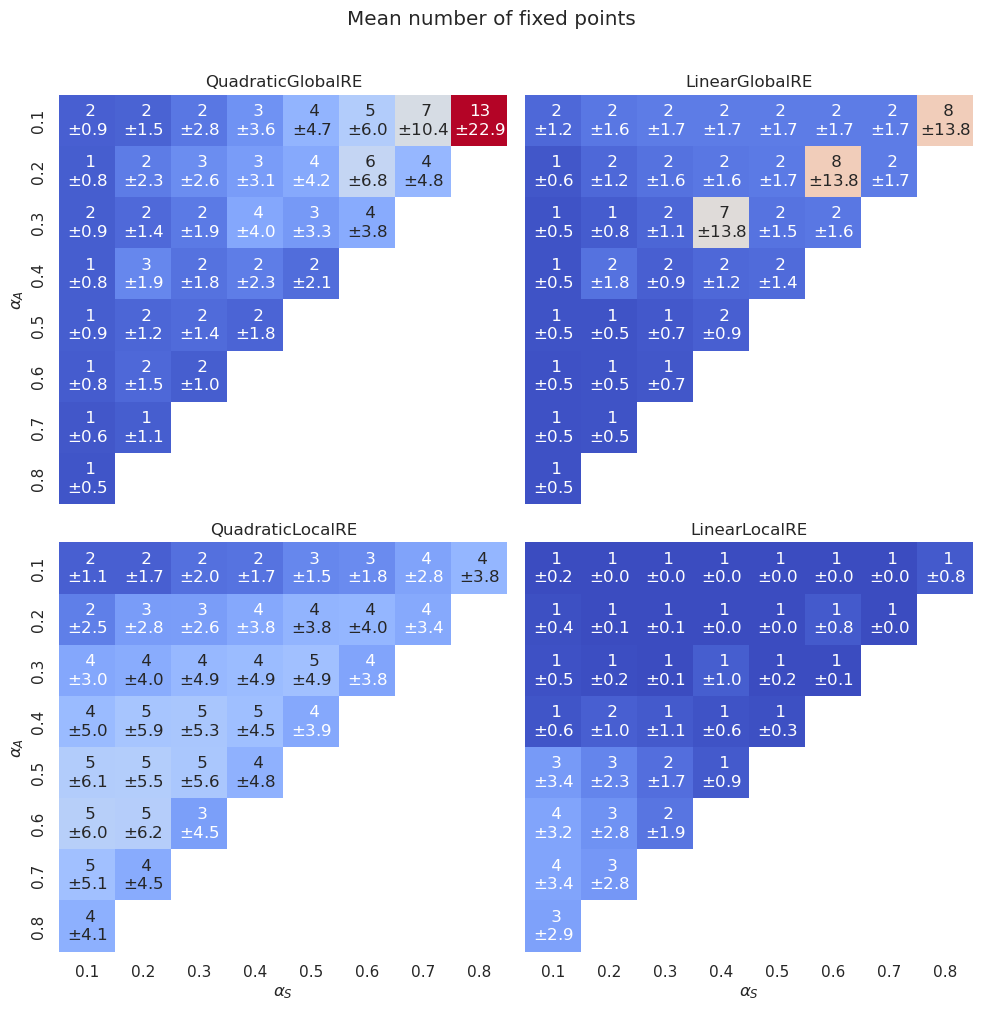

In [43]:
heat_maps_by_weights(re_data = data_collapsed, 
                     values = 'n_fixed_points', 
                     title = 'Mean number of fixed points', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=13,
                     file_name='hm-mean-n-fixed-points', output_dir=figures_output_dir)

### Counting branches

In [44]:
# Cols that should have identical values for all branches (and only for those) that belong to one branching model run
cols_group_branches = ['model_name', 'ds','init_coms', 'weight_account', 'weight_systematicity', 'weight_faithfulness', 'n_sentence_pool'] 
#cols_group_branches = ['model_name', 'model_short_name', 'ds','init_coms', 'weight_account', 'weight_systematicity', 'weight_faithfulness'] 

# Calculating the number of branches for each model run
df_branches = DataFrame({'n_branches' : re_data.groupby(cols_group_branches).size()}).reset_index()

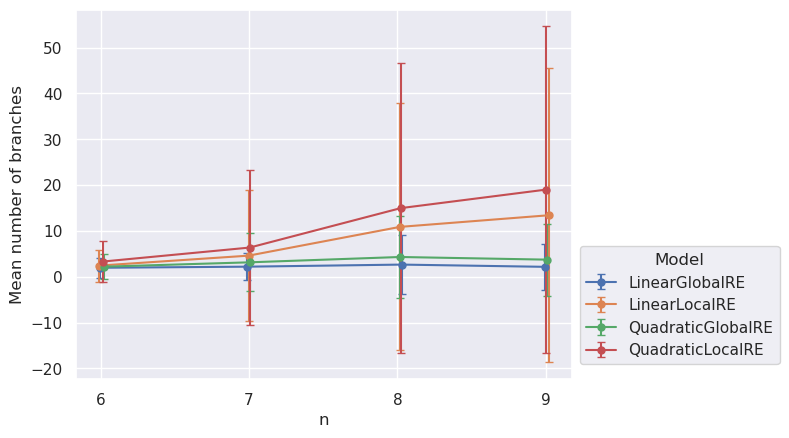

In [45]:
plot_multiple_error_bars(data=df_branches, 
                         var_y='n_branches', 
                         ylabel='Mean number of branches',
                         file_name='mean-branches', output_dir=figures_output_dir)

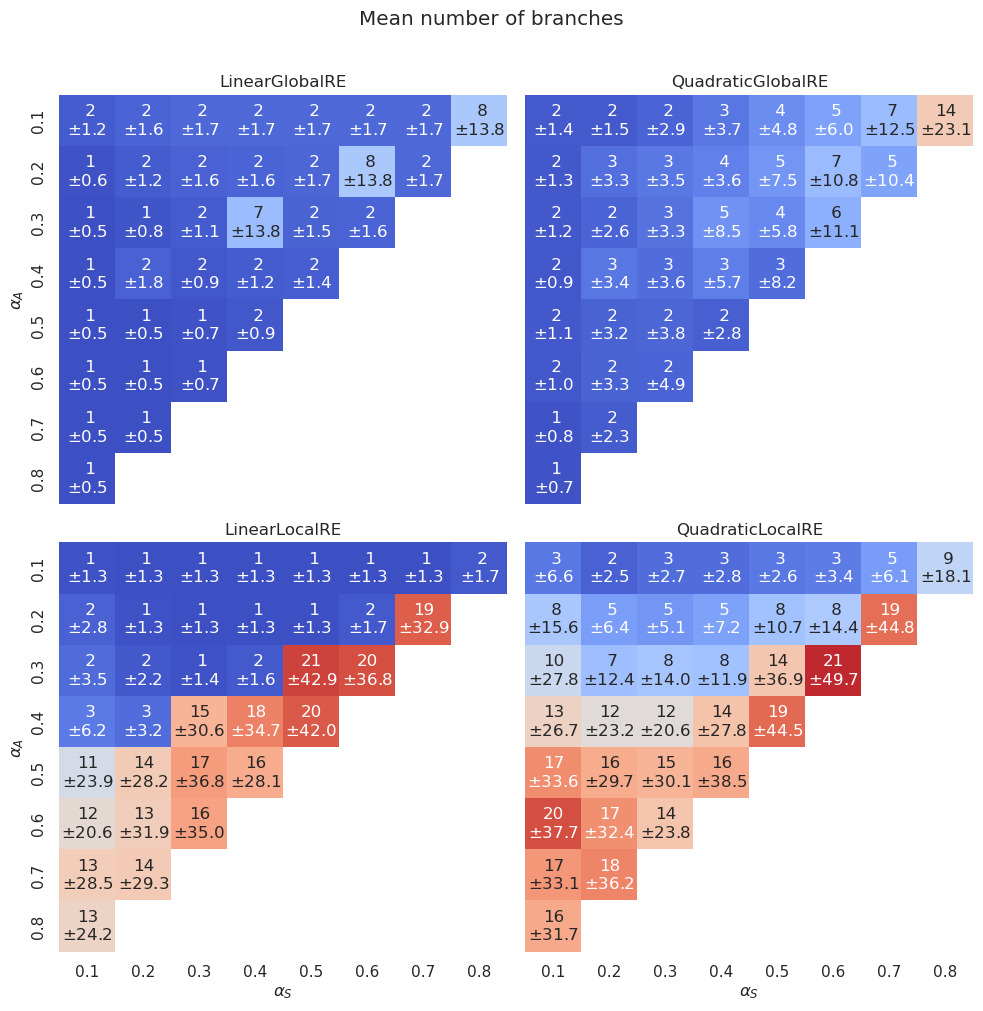

In [46]:
heat_maps_by_weights(re_data = df_branches, values = 'n_branches', 
                     title = 'Mean number of branches', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=22,
                     file_name='hm-mean-branches', output_dir=figures_output_dir,
                     col_order=['LinearGlobalRE', 'QuadraticGlobalRE',
                                'LinearLocalRE', 'QuadraticLocalRE'])